<a href="https://colab.research.google.com/github/Xiaoyu-Su-20/Novartis-Hackathon/blob/main/Novartis_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Novartis Hackathon. 

Novartis Hackathon concerns building model to predict events regarding metastatic breast cancer (MBC) patients. Metastatic breast cancer is breast cancer that has spread to another part of the body, most commonly the liver, brain, bones, or lungs. Nearly 30% of women diagnosed with early-stage breast cancer will develop metastatic disease.

In this competition, a primary objective is to predict when an MBC patient would move to a new line of treatment. Specifically, using the data from the first month of a patients treatment, we want to predict when the patient will come back to get a new treatment.

The data of this project is stored in several tables and here are their descriptions:

DIAG_2l: The Diagnosis information of patients.

BS_SN ICD Code: The table that maps diagnosis code to cancer type. (This is used for finding MBC patients.

PX: The procedure information of patients.

RX: The prescription (e.g drugs) information of patients.

Drug_ReferenceReference: Map drug_id to drug_names. 


In [ ]:
# necessary imports
import numpy as np
import pandas as pd
import datetime
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Since the patients in DIAG_2l Table are not all MBC patients, we have to find MBC Patients first. MBC patients is defiend as the patients who were diagnosed as having BC (breast cancer) and SN (metastasis) diagnosis together. Specifically for this problem, a patient is defined as MBC if SN diagnosis is no earlier than 30 days before the diagnosis of BC.   

In [ ]:
BC_SN_Code = pd.read_excel('/content/drive/My Drive/Novartis/BC_SN ICD Code.xlsx',header=0)
DIAG2 = pd.read_csv('/content/drive/My Drive/Novartis/DIAG_2l.txt', sep='|',parse_dates=['SERVICE_DATE'])

In [ ]:
# join BC_SN_Code and DIAG_df on DIAGNOSIS_CODE
DIAG_df = DIAG2.merge(BC_SN_Code, how='left',left_on='DIAGNOSIS_CODE',right_on='diagnosis_cd')
del BC_SN_Code

In [ ]:
"""
Find MBC patients
"""
SN = DIAG_df[DIAG_df['indication_cd']=='SN'].groupby('PATIENT_ID').agg({'SERVICE_DATE': 'min','indication_cd':'min'})
SN = SN.rename(columns={'SERVICE_DATE':'SERVICE_DATE_SN'})
BC = DIAG_df[DIAG_df['indication_cd']=='BC'].groupby('PATIENT_ID').agg({'SERVICE_DATE': 'min','indication_cd':'min'})
BC = BC.rename(columns={'SERVICE_DATE':'SERVICE_DATE_BC'})

# merge BC and SN
SNBC = BC.merge(SN, how='inner', on='PATIENT_ID').reset_index()

In [ ]:
# compute 30 day diff
SNBC['date_diff'] = SNBC['SERVICE_DATE_SN'] - SNBC['SERVICE_DATE_BC']
SNBC['date_diff'] = SNBC['date_diff'].apply(lambda x:x.days)

# if metastatic diagnose no earlier than 30 days of breast cancer diagnose,
# then metastatic breast cancer 
SNBC = SNBC[SNBC['date_diff'] >= -30]
SNBC = SNBC[['PATIENT_ID', 'date_diff']]

In [ ]:
# find MBC patients in DIAG2 can write to a csv file 
MBC_DIAG = DIAG2.merge(SNBC, how='right', on='PATIENT_ID')

MBC_DIAG.to_csv('/content/drive/My Drive/Novartis/MBC_DIAG.csv')

In [ ]:
# this is the result table 
pd.read_csv('/content/drive/My Drive/Novartis/MBC_DIAG.csv').head()

,PATIENT_ID,CLAIM_ID,CLAIM_TYP_CD,SERVICE_DATE,MONTH_ID,DIAGNOSIS_CODE,DIAG_VERS_TYP_ID,DIAG_CD_POSN_NBR,PROVIDER_ID,RESTATE_FLAG,FLEXIBLE_FLD_1_CHAR,FLEXIBLE_FLD_2_CHAR,date_diff
0,29360529,131679393582,P,2016-03-25,201603,C50.419,2,1,7655074,0,1.508863e+09,NaN,1642
1,29360529,131679228847,P,2016-03-25,201603,C50.419,2,1,7655074,0,1.508863e+09,NaN,1642
2,29360529,131677762461,P,2016-03-25,201603,C50.419,2,1,7655074,0,1.508863e+09,NaN,1642
3,29360529,124208425245,P,2015-09-11,201509,174.4,1,1,7655074,0,1.508863e+09,NaN,1642
4,29360529,124157215617,P,2015-09-11,201509,174.4,1,1,7655074,0,1.508863e+09,NaN,1642


In [ ]:
# find the list of mbc patients 
pd.DataFrame(SNBC.PATIENT_ID.nunique()).to_csv('/content/drive/My Drive/Novartis/mbc_patients.csv', index=False)

Define Line 1 and Line 2 Therapy starting date. 

L1_Date is the first service date ever and the L1 period is defined as the first month of the treatment. After this treatment is over, the next service_date is the L2_Date.

In [ ]:
# since we dropped the missing data in NDC column, RP2 is not full information for MBC patients;
# RP2_full is the full information
RP2_full = PX2.append(RX2).drop(['drug_id','DSPNSD_QTY'],axis=1)

# choose only the MBC patients
RP2_full = RP2_full.merge(MBC_patients, how='right', on='PATIENT_ID')

# find unique(patient_id, service_date) pairs
RP2_Date = RP2_full[['PATIENT_ID','SERVICE_DATE']].drop_duplicates().sort_values(['PATIENT_ID','SERVICE_DATE'])
RP2_Date['SERVICE_DATE'] = pd.to_datetime(RP2_Date['SERVICE_DATE'])


In [ ]:
# method to find L2 
def find_second_date(x):
  # idk why but Series seem to have some problems
  x = list(x)

  # x[0] is the first date since x is sorted
  first_date = x[0]

  # if no second date, return None
  if len(x) == 1: return None

  for i in range(1, len(x)):
    # find the first 30 day gap
    if x[i] - first_date >= datetime.timedelta(days=30):
      break
    # if at the end of the list, return None
    if i == len(x) - 1: return None

  # don't want the hh:mm:ss part
  return x[i].date()

In [ ]:
# find L1 and L2 Date 
RP2_L1L2 = RP2_Date.groupby('PATIENT_ID').agg(
    L1_DATE=('SERVICE_DATE', 'min'), L2_DATE=('SERVICE_DATE', find_second_date)
).reset_index()

# dropna if no line 2 therapy
RP2_L1L2 = RP2_L1L2[~RP2_L1L2.L2_DATE.isna()]

# write the data to csv
RP2_L1L2.to_csv('/content/drive/My Drive/Novartis/RP2_L1L2.csv', index=False)

In [ ]:
# here is how the data looks like 
line = pd.read_csv('/content/drive/My Drive/Novartis/RP2_L1L2.csv', parse_dates= [1,2])
line.head()

,PATIENT_ID,L1_DATE,L2_DATE
0,29360529,2013-09-20,2013-12-17
1,29425424,2013-09-13,2013-12-10
2,29494927,2013-09-27,2013-11-25
3,29531186,2014-06-12,2014-09-30
4,29537719,2013-09-13,2013-10-24


Next we are going to find the procedures and prescriptions associated with each MBC patients. The procedures table is PX and the prescription table is RX. The first thing to do is to find all the drugs asscociated with each patients.Using the Drug_Reference table, we can find the drug names and brand. We only want to keep the 10 most prevalent drug brands and assign all the other drugs to OTHERS.

In [ ]:
# load the data, 20 million cols 
PX = pd.read_csv('/content/drive/My Drive/Novartis/PX.csv', parse_dates=['SERVICE_DATE'])
RX = pd.read_csv('/content/drive/My Drive/Novartis/RX_2l.txt', sep='|', parse_dates=['SERVICE_DATE'])

In [ ]:
# select only the informative columns for PX
PX = PX[['PATIENT_ID','SERVICE_DATE','NDC','UNIT_OF_SVC_AMT']]
# NDC rename as drug_id
PX = PX.rename({'UNIT_OF_SVC_AMT':'DSPNSD_QTY', 'NDC':'drug_id'},axis=1)

# select only the informative columns for RX
RX = RX[['PATIENT_ID','SERVICE_DATE','NDC','DSPNSD_QTY']]
# NDC rename as drug_id
RX = RX.rename({'NDC':'drug_id'},axis=1)

# filter the ones that does not have a drug_id
PX_ndc = PX[~PX.drug_id.isna()]

# combine RX and PX
RP2 = RX.append(PX_ndc)

In [ ]:
# merge with the drug_name table to gain the names of drug
RP2 = RP2.merge(Product[['DRUG_NAME','DRUG_GENERIC_NAME']], left_on='drug_id', right_on='NDC', how='inner')

In [ ]:
# Branding rules from the Q&A slides
def branding_drugs(row):
  drug_generic_name = row['DRUG_GENERIC_NAME']
  drug_name = row['DRUG_NAME']
  if isinstance(drug_generic_name,float):
    drug_generic_name = ''
  if isinstance(drug_name, float):
    drug_name = ''
  if 'PALBOCICLIB' in drug_generic_name or 'IBRANCE' in drug_name:
    brand = 'IBR'
  elif 'FULVESTRANT' in drug_generic_name or 'FASLODEX' in drug_name:
    brand = 'FAS'
  elif 'RIBOCICLIB' in drug_generic_name or 'KISQALI' in drug_name or 'KISQALI FEMARA' in drug_name or 'RIBOCICLIB SUCCINATE-LETROZOLE' in drug_generic_name:
    brand = 'KIS'
  elif 'EVEROLIMUS' in drug_generic_name or 'AFINITOR' in drug_name:
    brand = 'AFI'
  elif 'LETROZOLE' in drug_generic_name or 'FEMARA' in drug_name:
    brand = 'LET'
  elif 'ABEMACICLIB' in drug_generic_name or 'VERZENIO' in drug_name:
    brand = 'VER'
  elif 'CHEMO' in drug_generic_name or 'CHEMO' in drug_name:
    brand = 'CHEMO'
  elif 'CAPECITABINE' in drug_generic_name or 'XELODA' in drug_name:
    brand = 'XEL'
  elif 'TAMOXIFEN CITRATE' in drug_name:
    brand = 'TAM'
  elif 'ANASTROZOLE' in drug_generic_name or 'EXEMESTANE' in drug_generic_name or 'ANASTROZOLE' in drug_name or 'ARIMIDEX' in drug_name or 'EXEMESTANE' in drug_name or 'AROMASIN' in drug_name or 'NOLVADEX' in drug_name or 'SOLTAMOX' in drug_name:
    brand = 'AI'
  else:
    brand = 'OTHERS'
  return brand

In [ ]:
# define drug_brand
RP2['drug_brand'] = RP2.apply(branding_drugs, axis=1)
RP2 = RP2.drop(['DRUG_NAME','DRUG_GENERIC_NAME'],axis=1)
# choose only the MBC patients
RP2 = RP2.merge(MBC_patients, how='right', on='PATIENT_ID')

In [ ]:
# store the table
RP2.to_csv('/content/drive/My Drive/Novartis/RP2_drug.csv', index=False)

In [ ]:
# take a look at the data
drug = pd.read_csv('/content/drive/My Drive/Novartis/RP2_drug.csv')
drug.head()

,PATIENT_ID,SERVICE_DATE,drug_id,DSPNSD_QTY,drug_brand
0,29360529,2017-01-15 00:00:00,93762056.0,30.0,LET
1,29360529,2016-12-16 00:00:00,93762056.0,30.0,LET
2,29360529,2016-11-16 00:00:00,93762056.0,30.0,LET
3,29360529,2016-10-17 00:00:00,93762056.0,30.0,LET
4,29360529,2016-09-17 00:00:00,93762056.0,30.0,LET


Here is a plot of the prevalence of the drug brands.

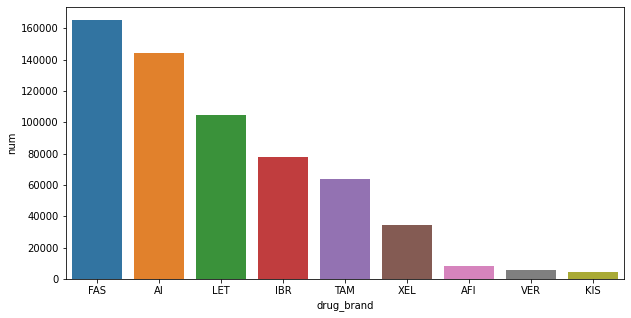

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# count drug instances and plot
drug_count = RP2_drug.drug_brand.value_counts().to_frame().reset_index().rename(columns={'index':'drug_brand','drug_brand':'num'}).iloc[1:]

fig = plt.figure(figsize=(10,5))
fig = sns.barplot(x='drug_brand', y='num',data=drug_count)

To convert these drugs to features, we are going to aggregate the drugs and their respective quantity for line 1 and line 2 periods.

In [ ]:
# read the tables
patients = pd.read_csv('/content/drive/My Drive/Novartis/MBC_patients.csv')
drug = pd.read_csv('/content/drive/My Drive/Novartis/RP2_drug.csv', parse_dates=['SERVICE_DATE'])
line = pd.read_csv('/content/drive/My Drive/Novartis/RP2_L1L2.csv', parse_dates= [1,2])

# making sure that we are only including the mbc patients 
drug = drug.merge(patients, on='PATIENT_ID')

line = line.merge(patients, on='PATIENT_ID')

# drop if the date is missing 
drug = drug[~drug.SERVICE_DATE.isna()]

In [ ]:
# add the L2_DATE column to differentiate between line1 and line2 drugs
drug = drug.merge(line[['PATIENT_ID','L2_DATE']], on='PATIENT_ID')

# define a new column signaling line1 and line2 therapy
drug['therapy'] = drug['SERVICE_DATE'] < drug['L2_DATE']

# assign True (line1) to 1, False (line2) to 2
drug.loc[drug['therapy'] == True, 'therapy'] = 1 
drug.loc[drug['therapy'] == False, 'therapy'] = 2 

In [ ]:
# count drugs and sum the dosage for line1 and line2 periods
count_drug = drug.groupby(['PATIENT_ID', 'therapy','drug_brand']).agg(
  count = ('drug_brand','size'),
  quantity = ('DSPNSD_QTY','sum')
)

count_drug = count_drug.reset_index().rename(columns={'count':'num'})

In [ ]:
# take a look at the count_drug table
count_drug.head()

,PATIENT_ID,therapy,drug_brand,num,quantity
0,29360529,1,TAM,1,180.0
1,29360529,2,IBR,3,63.0
2,29360529,2,LET,24,1020.0
3,29360529,2,OTHERS,206,5463.0
4,29360529,2,TAM,5,900.0


To aggregate the drugs for every patient, create a count dictionary and iterate through every row.

In [ ]:
# define a patient_drug_dic for storing drugs and their respective count for a particular patient
lst = drug.drug_brand.unique().tolist()
lst_12 = [i+'_1' for i in lst] + [i+'_2' for i in lst] + [i+'_qty1' for i in lst] +[i+'_qty2' for i in lst]
drug_dic = {i:0 for i in lst_12}
patient_lst = line.PATIENT_ID.unique().tolist()

patient_drug_dic = {i:drug_dic.copy() for i in patient_lst}

# as an example 
print(patient_drug_dic[29360529])

{'LET_1': 0, 'IBR_1': 0, 'XEL_1': 0, 'OTHERS_1': 0, 'TAM_1': 0, 'AFI_1': 0, 'VER_1': 0, 'FAS_1': 0, 'AI_1': 0, 'KIS_1': 0, 'LET_2': 0, 'IBR_2': 0, 'XEL_2': 0, 'OTHERS_2': 0, 'TAM_2': 0, 'AFI_2': 0, 'VER_2': 0, 'FAS_2': 0, 'AI_2': 0, 'KIS_2': 0, 'LET_qty1': 0, 'IBR_qty1': 0, 'XEL_qty1': 0, 'OTHERS_qty1': 0, 'TAM_qty1': 0, 'AFI_qty1': 0, 'VER_qty1': 0, 'FAS_qty1': 0, 'AI_qty1': 0, 'KIS_qty1': 0, 'LET_qty2': 0, 'IBR_qty2': 0, 'XEL_qty2': 0, 'OTHERS_qty2': 0, 'TAM_qty2': 0, 'AFI_qty2': 0, 'VER_qty2': 0, 'FAS_qty2': 0, 'AI_qty2': 0, 'KIS_qty2': 0}


In [ ]:
# count drug instances 
for index, row in count_drug.iterrows():
  patient = row.PATIENT_ID
  drug_name = row.drug_brand
  line_therapy = str(row.therapy)
  num = row['num']
  qty = row.quantity
  patient_drug_dic[patient][drug_name + '_' + line_therapy] = num
  patient_drug_dic[patient][drug_name + '_qty' + line_therapy] = qty

# the results for the same patient 
print(patient_drug_dic[29360529])

{'LET_1': 0, 'IBR_1': 0, 'XEL_1': 0, 'OTHERS_1': 0, 'TAM_1': 1, 'AFI_1': 0, 'VER_1': 0, 'FAS_1': 0, 'AI_1': 0, 'KIS_1': 0, 'LET_2': 24, 'IBR_2': 3, 'XEL_2': 12, 'OTHERS_2': 206, 'TAM_2': 5, 'AFI_2': 0, 'VER_2': 0, 'FAS_2': 0, 'AI_2': 0, 'KIS_2': 0, 'LET_qty1': 0, 'IBR_qty1': 0, 'XEL_qty1': 0, 'OTHERS_qty1': 0, 'TAM_qty1': 180.0, 'AFI_qty1': 0, 'VER_qty1': 0, 'FAS_qty1': 0, 'AI_qty1': 0, 'KIS_qty1': 0, 'LET_qty2': 1020.0, 'IBR_qty2': 63.0, 'XEL_qty2': 1008.0, 'OTHERS_qty2': 5463.0, 'TAM_qty2': 900.0, 'AFI_qty2': 0, 'VER_qty2': 0, 'FAS_qty2': 0, 'AI_qty2': 0, 'KIS_qty2': 0}


In [ ]:
# transform patient_drug_dic so that it can be converted to a dataframe 
pd_list = []
for key, value in patient_drug_dic.items():
  dic = {'PATIENT_ID':key}
  dic.update(value)
  pd_list.append(dic)

del patient_drug_dic

drug_aggregated = pd.DataFrame(pd_list)
drug_aggregated.head()

,PATIENT_ID,LET_1,IBR_1,XEL_1,OTHERS_1,TAM_1,AFI_1,VER_1,FAS_1,AI_1,KIS_1,LET_2,IBR_2,XEL_2,OTHERS_2,TAM_2,AFI_2,VER_2,FAS_2,AI_2,KIS_2,LET_qty1,IBR_qty1,XEL_qty1,OTHERS_qty1,TAM_qty1,AFI_qty1,VER_qty1,FAS_qty1,AI_qty1,KIS_qty1,LET_qty2,IBR_qty2,XEL_qty2,OTHERS_qty2,TAM_qty2,AFI_qty2,VER_qty2,FAS_qty2,AI_qty2,KIS_qty2
0,29360529,0,0,0,0,1,0,0,0,0,0,24,3,12,206,5,0,0,0,0,0,0.0,0.0,0.0,0.0,180.0,0.0,0.0,0.0,0.0,0.0,1020.0,63.0,1008.0,5463.0,900.0,0.0,0.0,0.0,0.0,0.0
1,29425424,0,0,0,0,0,0,0,0,0,0,0,4,0,23,0,3,22,21,21,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,0.0,2753.0,0.0,84.0,1232.0,420.0,1048.0,0.0
2,29494927,0,0,0,4,0,0,0,0,0,0,0,0,0,378,0,0,0,0,3,0,0.0,0.0,0.0,270.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24975.0,0.0,0.0,0.0,0.0,270.0,0.0
3,29531186,0,0,0,0,0,0,0,0,0,0,3,0,0,291,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,16289.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29537719,0,0,0,0,0,0,0,0,1,0,0,0,6,615,0,11,0,42,41,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,504.0,24375.0,0.0,308.0,0.0,732.0,1516.0,0.0


In [ ]:
# write drug_encoded to a csv file 
drug_aggregated.to_csv('/content/drive/My Drive/Novartis/drug_aggregated.csv', index=False)

Next we are going to collect information from the procedures exclusively in the PX table.

In [ ]:
# count the procedure in L1 ad L2 and select top 300 
procedure_lst = PX.PROCEDURE_CODE.value_counts().head(300).index.tolist()

# make a dictionary to count for every patient 
procedure_12 = [i+'_1' for i in procedure_lst] + [i+'_2' for i in procedure_lst]
procedure_dic = {i:0 for i in procedure_12}
patient_lst = line.PATIENT_ID.unique().tolist()

patient_procedure_dic = {i:procedure_dic.copy() for i in patient_lst}

In [ ]:
PX = PX[['PATIENT_ID', 'PROCEDURE_CODE', 'SERVICE_DATE']]
PX = PX.merge(line[['PATIENT_ID','L2_DATE']], on='PATIENT_ID')

In [ ]:
# return True if L1
PX['line1'] = PX['SERVICE_DATE'] < PX['L2_DATE']

# assign True to 1, False to 2
PX.loc[PX['line1'] == True, 'line1'] = 1 
PX.loc[PX['line1'] == False, 'line1'] = 2 

In [ ]:
# count procedure for line1 and line2 periods for every patients
count_procedure = PX.groupby(['PATIENT_ID', 'line1','PROCEDURE_CODE']).agg(
  count = ('PROCEDURE_CODE','size')
)

count_procedure = count_procedure.reset_index().rename(columns={'count':'num'})

# remove PX table
del PX

In [ ]:
count_procedure.head()

,PATIENT_ID,line1,PROCEDURE_CODE,num
0,29360529,1,36415,2
1,29360529,1,85025,2
2,29360529,1,96523,2
3,29360529,1,99214,2
4,29360529,2,00402,2


In [ ]:
# count procedure instances 
procedure_set = set(procedure_lst)

for index, row in count_procedure.iterrows():
  procedure = row.PROCEDURE_CODE

  # if not top 20, skip
  if procedure not in procedure_set:
    continue  

  # otherwise, add count to the dictionary
  patient = row.PATIENT_ID
  line_therapy = '_' + str(row.line1)
  num = row['num']
  patient_procedure_dic[patient][procedure + line_therapy] = num

In [ ]:
print(patient_procedure_dic[29360529])

{'85025_1': 2, '80053_1': 0, '99214_1': 2, '96413_1': 0, '36415_1': 2, 'J1100_1': 0, 'J9395_1': 0, '96402_1': 0, '86300_1': 0, '96375_1': 0, '96372_1': 0, '99213_1': 0, '77412_1': 0, '96367_1': 0, 'J0897_1': 0, 'J9267_1': 0, '99215_1': 0, 'J1200_1': 0, '96365_1': 0, 'G0463_1': 0, 'J7050_1': 0, 'J9070_1': 0, 'J1642_1': 0, 'J2405_1': 0, '82378_1': 0, 'J2469_1': 0, 'J3489_1': 0, '71260_1': 0, '36591_1': 0, '77336_1': 0, 'J9000_1': 0, '96411_1': 0, '83735_1': 0, '74177_1': 0, '96417_1': 0, 'J2505_1': 0, 'J1626_1': 0, '83615_1': 0, '77387_1': 0, 'J9264_1': 0, 'J3490_1': 0, '96401_1': 0, '77427_1': 0, '78815_1': 0, '99211_1': 0, '96409_1': 0, '77334_1': 0, 'G6002_1': 0, 'Q9967_1': 0, '85027_1': 0, '96415_1': 0, 'J1453_1': 0, 'J7040_1': 0, 'G9678_1': 0, '80048_1': 0, '84100_1': 0, 'J9171_1': 0, 'G6013_1': 0, '88305_1': 0, '78306_1': 0, 'A9552_1': 0, '77417_1': 0, '77014_1': 0, 'J9179_1': 0, 'J9202_1': 0, 'J7030_1': 0, 'J9201_1': 0, '96361_1': 0, '99212_1': 0, 'G0299_1': 0, '77300_1': 0, 'J935

In [ ]:
# transform patient_procedure_dic so that it can be converted to a dataframe 
pd_list = []
for key, value in patient_procedure_dic.items():
  dic = {'PATIENT_ID':key}
  dic.update(value)
  pd_list.append(dic)

del patient_procedure_dic

procedure_aggregated = pd.DataFrame(pd_list)
procedure_aggregated.to_csv('/content/drive/My Drive/Novartis/procedure_aggregated300.csv', index=False)

del procedure_aggregated

In [ ]:
# take a look at the procedure_aggregated table 
pd.read_csv('/content/drive/My Drive/Novartis/procedure_aggregated300.csv').head()

,PATIENT_ID,85025_1,80053_1,99214_1,96413_1,36415_1,J1100_1,J9395_1,96402_1,86300_1,96375_1,96372_1,99213_1,77412_1,96367_1,J0897_1,J9267_1,99215_1,J1200_1,96365_1,G0463_1,J7050_1,J9070_1,J1642_1,J2405_1,82378_1,J2469_1,J3489_1,71260_1,36591_1,77336_1,J9000_1,96411_1,83735_1,74177_1,96417_1,J2505_1,J1626_1,83615_1,77387_1,...,A9579_2,0159T_2,96549_2,J3480_2,88173_2,99284_2,99244_2,71010_2,88374_2,A4648_2,77066_2,A9577_2,77373_2,77418_2,J9022_2,J9035_2,J2430_2,99231_2,J9354_2,38505_2,84132_2,G0154_2,Q9968_2,97112_2,88333_2,93010_2,74178_2,96376_2,00400_2,87040_2,G0008_2,J0330_2,G9557_2,A9575_2,J1040_2,G0279_2,99222_2,99153_2,77051_2,P9016_2
0,29360529,2,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,29425424,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,7,0,0,0,0,0,2,0,0,0,4,0,0,2
2,29494927,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0
3,29531186,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,0,2,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,0,0,0,0,0,4,0,0
4,29537719,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0,0,3,0


Now that we've finally leveraged the data in the PX and RX file, let's put them together to form a prepared table.

In [ ]:
# the data to use 

# supportive table
line = pd.read_csv('/content/drive/My Drive/Novartis/RP2_L1L2.csv', parse_dates= [1,2])

patients = pd.read_csv('/content/drive/My Drive/Novartis/MBC_patients.csv')

# features table 
drug = pd.read_csv('/content/drive/My Drive/Novartis/drug_aggregated.csv')

procedure = pd.read_csv('/content/drive/My Drive/Novartis/procedure_aggregated300.csv')

mbc_diag = pd.read_csv('/content/drive/My Drive/Novartis/MBC_DIAG.csv')

In [ ]:
# make sure include only the mbc patients 
drug = drug.merge(patients, on='PATIENT_ID')
line = line.merge(patients, on='PATIENT_ID')

In [ ]:
# define mode of a Series
def mode(row):
    x = list(row)
    return max(set(x), key=x.count)

In [ ]:
# aggregated information from DIAGNOSIS table 
mbc_model1 = mbc_diag[['PATIENT_ID', 'CLAIM_TYP_CD','DIAGNOSIS_CODE','DIAG_VERS_TYP_ID','DIAG_CD_POSN_NBR']].groupby('PATIENT_ID').agg(
    CLAIM_TYP_CD = ('CLAIM_TYP_CD', mode),
    DIAGNOSIS_CODE = ('DIAGNOSIS_CODE', mode),
    DIAG_VERS_TYP_ID = ('DIAG_VERS_TYP_ID', mode),
    DIAG_CD_POSN_NBR = ('DIAG_CD_POSN_NBR', mode)
)

del mbc_diag

In [ ]:
# merge the tables together to form a prepared table 
line_model1 = line.merge(mbc_model1, how='left', on='PATIENT_ID')
line_model1 = line_model1.merge(procedure, how='left', on='PATIENT_ID')
line_model1 = line_model1.merge(drug, how='left', on='PATIENT_ID')


line_model1['diff'] = (line_model1['L2_DATE'] - line_model1['L1_DATE']).dt.days
line_model1 = line_model1.drop(['L1_DATE','L2_DATE'], axis=1)

line_model1.to_csv('/content/drive/My Drive/Novartis/obj2_data.csv', index=False)

Now that we've prepared our table, we can finally start building models. See the next notebook for detail.